In [1]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import jaccard_score

import staple


In [2]:
def show(src, titles=[], suptitle="", 
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False):

    num_cols = len(src)
    
    plt.figure(figsize=(bwidth * num_cols, bheight))
    plt.suptitle(suptitle)

    for idx in range(num_cols):
        plt.subplot(1, num_cols, idx+1)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
        
def show2(src, titles=[], suptitle="", 
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False):

    num_cols = len(src)
    
    plt.figure(figsize=(bwidth * num_cols//2, bheight*2))
    plt.suptitle(suptitle)

    for idx in range(num_cols):
        plt.subplot(2, num_cols//2, idx+1)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)

# Data

In [3]:
R = 20 #num of segs
l = 40
N = l*l #num of image pixels

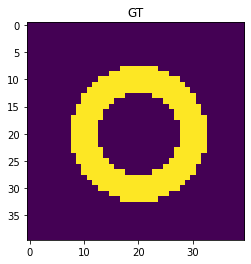

In [4]:
gt = np.zeros((l, l))
gt = cv2.circle(gt, (l//2, l//2), 10, (1), 3)
plt.imshow(gt)
plt.title("GT");

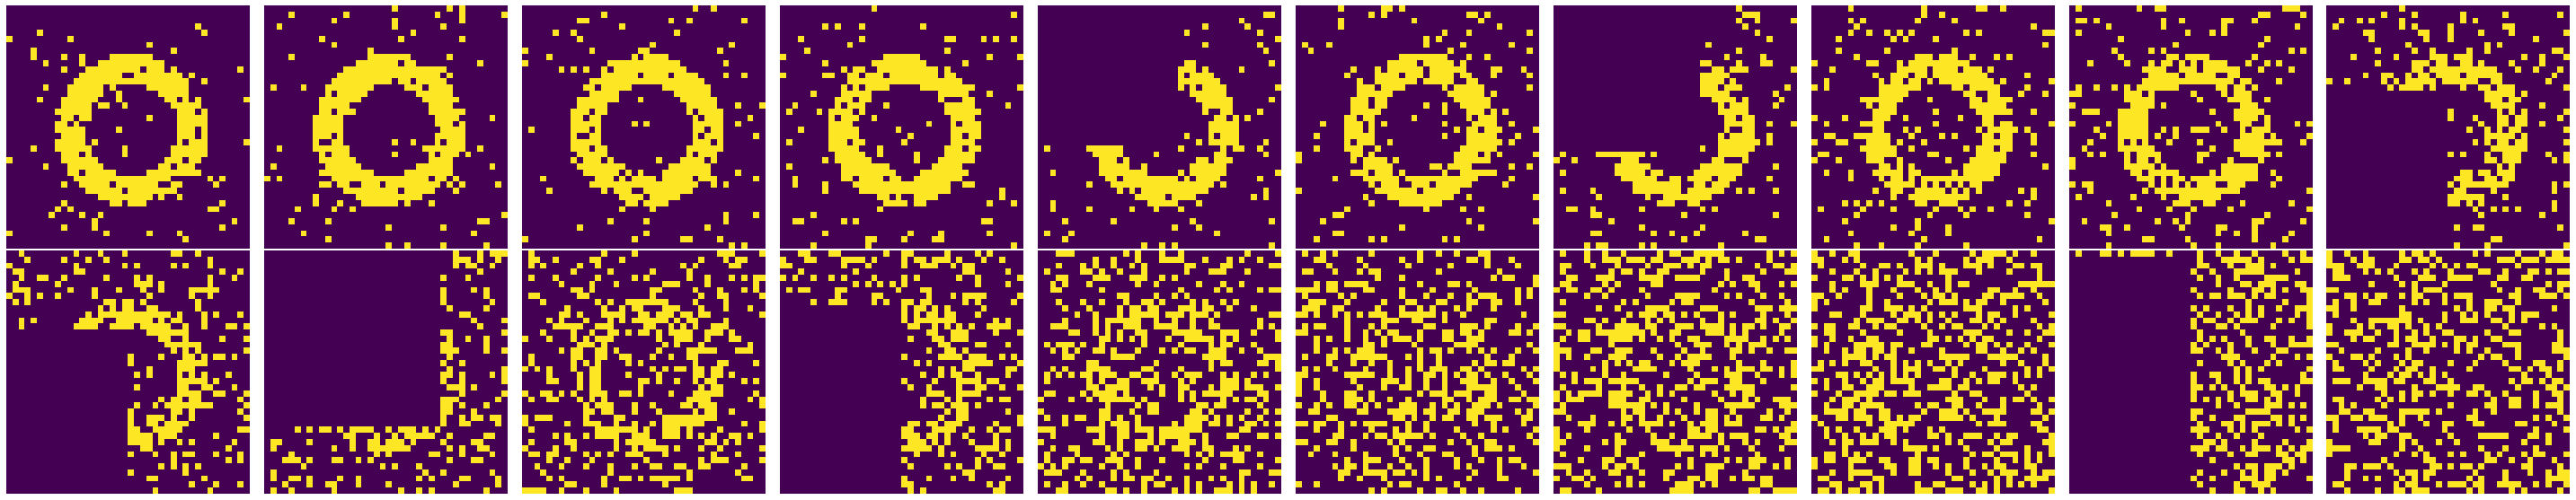

In [6]:
np.random.seed(2021)
p = 0.05
segs = []
metrics = []
for idx in range(R):
    
    p    += (idx/500)

    noise_type = idx % 2
    seg = gt.copy()
    if noise_type == 0:
        mask  = np.random.rand(l,l)
    if noise_type == 1:     
        mask  = np.random.normal(loc=127, scale=100, size=(l, l)).astype(np.uint8)/255
    
    if idx > 3:
        idr = np.random.randint(0, 10)
        if idr == 0:
            mask[:l//2+int(p*50), :l//2+int(p*50)] = 1
        if idr == 1:
            mask[l//2-int(p*50):, :l//2] = 1
        if idr == 2:
            mask[:l//2+int(p*50), l//2:] = 1
        if idr == 3:
            mask[l//2-int(p*50):, l//2:] = 1     

    salt  = mask < p
    peper = mask > 1-(2*p)+(p**2)

    seg[salt] = 1
    seg[peper] = 0

    segs.append(seg)
    recall  = recall_score(gt.ravel(), seg.ravel())
    prec    = precision_score(gt.ravel(), seg.ravel())
    jaccard = jaccard_score(gt.ravel(), seg.ravel())
    
    metrics.append([recall, prec, jaccard])
segs = np.array(segs)
metrics = np.array(metrics)
show2(segs, show_axis=False)

Text(0.5, 1.0, 'D Matrix')

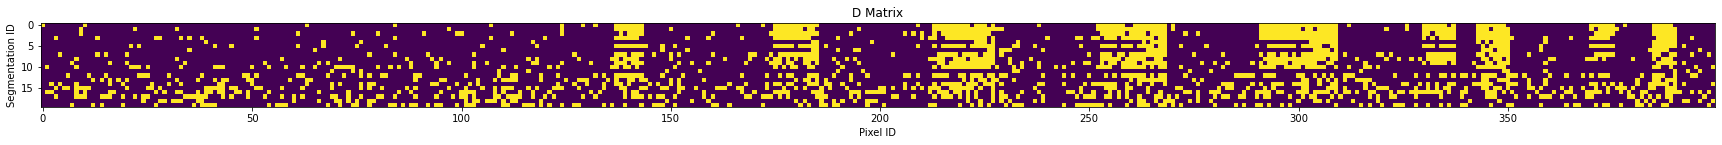

In [7]:
plt.figure(figsize=(30, 20))
plt.imshow(segs.reshape(segs.shape[0], -1)[:, 200:600])#.shape
plt.xlabel("Pixel ID")
plt.ylabel("Segmentation ID")
plt.title("D Matrix")

# STAPLE

In [8]:
## Note: metrics[0] recall, prec, jaccard]
T = gt.reshape(-1)
D = D = segs.reshape(segs.shape[0], -1).copy()
p = metrics[:, 0]
q = metrics[:, 1]
MV = (segs.sum(0)>= segs.shape[0]//2)

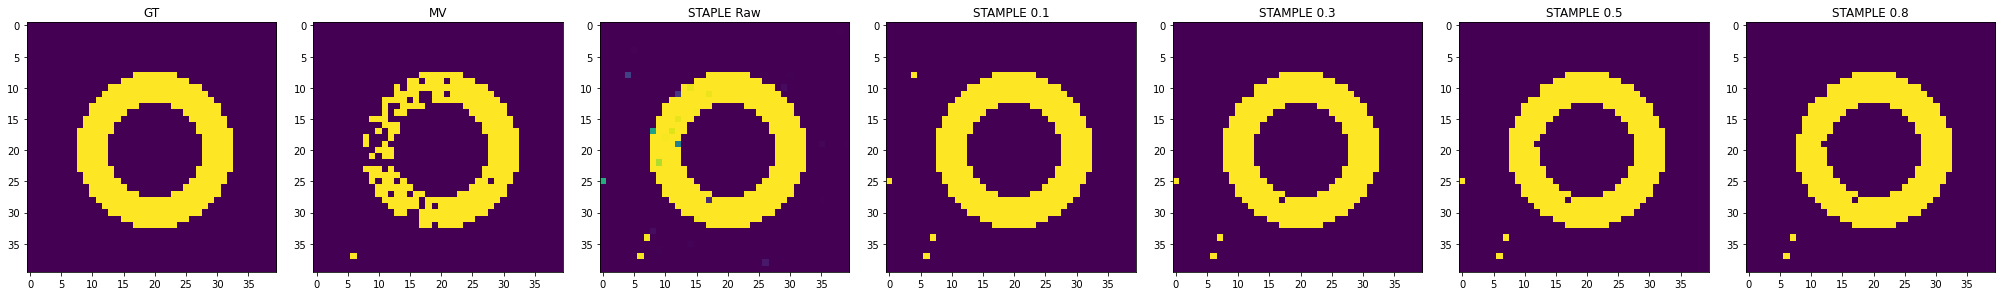

In [9]:

staple_res = staple.STAPLE(list(segs)).run()
show([gt, MV, staple_res, staple_res>0.1, staple_res>0.3, staple_res>0.5, staple_res>0.8],
      titles=["GT", "MV", "STAPLE Raw", "STAMPLE 0.1", "STAMPLE 0.3", "STAMPLE 0.5", "STAMPLE 0.8"])

# Non Weight Simple

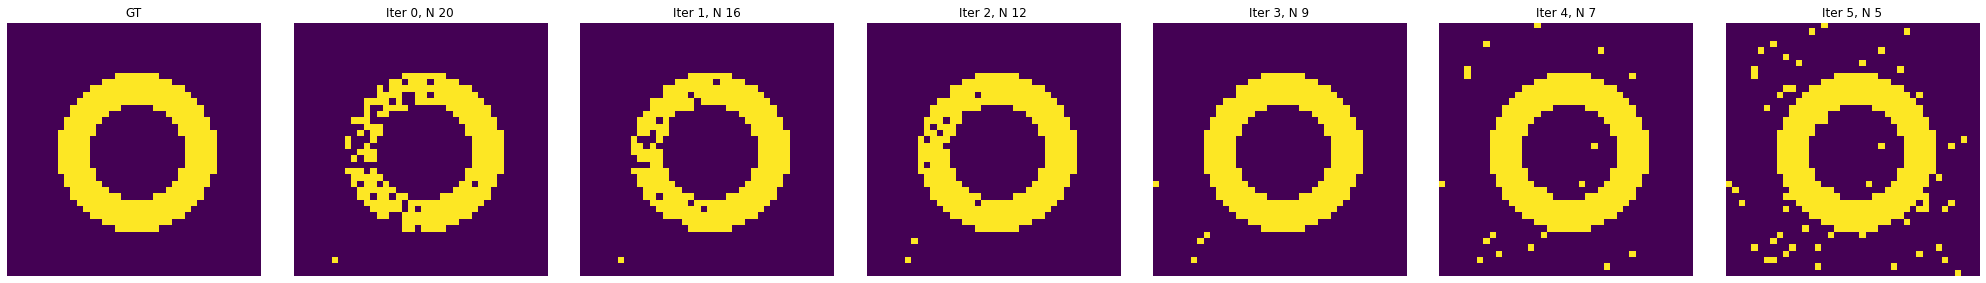

In [10]:
new_segs = segs.copy()
results, n_segs = [], []
alfa = 1
mdices = []

for epoch in range(6):
    MV = (new_segs.sum(0)>= new_segs.shape[0]//2)
    results.append(MV)
    n_segs.append(len(new_segs))
    seg_score = []
    for seg in new_segs:
        jac = jaccard_score(MV.ravel(), seg.ravel())
        dice = (2*jac)/ (1+jac)
        seg_score.append([dice, seg])


    seg_score  = np.array(seg_score, dtype=object)
    #sorted_seg = np.array(sorted(seg_score, key=lambda x:x[0], reverse=True))
    wdice = seg_score[:, 0].sum()
    mdice = seg_score[:, 0].mean()
    sdice = seg_score[:, 0].std()
    
    t = mdice - (alfa*sdice)
    new_segs = np.array((list(filter(lambda x: x[0]> t, seg_score))))[:, 1]
    
show([gt] + results, show_axis=False,titles=['GT'] + [f"Iter {idx}, N {n}" for idx, n in enumerate(n_segs)])

# SIMPLE

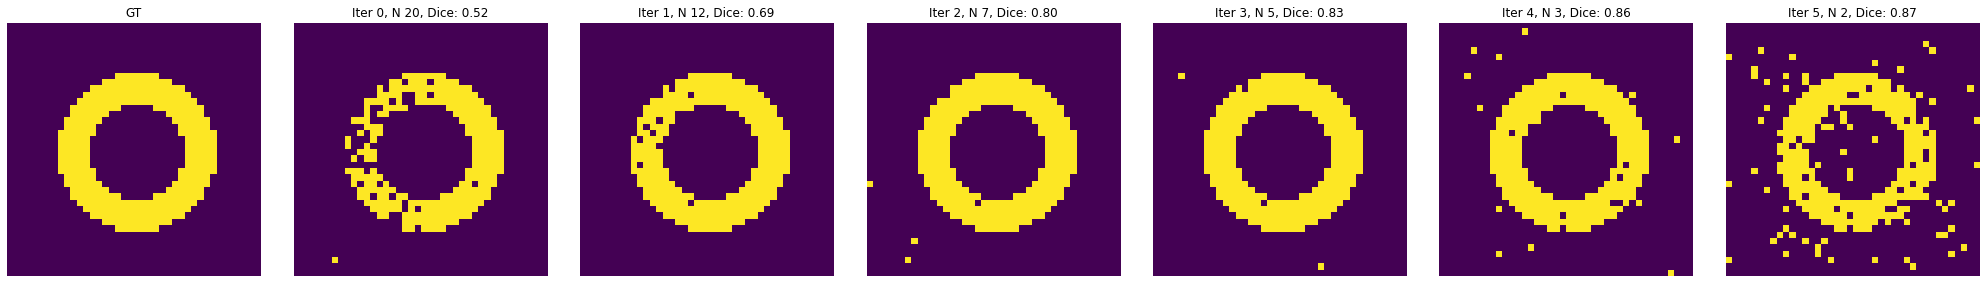

In [11]:
new_segs = segs.copy()
results, n_segs = [], []
alfa = 0.2
MV = (new_segs.sum(0)>= new_segs.shape[0]//2)
new_weights = np.ones(len(new_segs))
mdices = []

for epoch in range(6):
    
    MV = (new_segs.transpose(1,2,0) * new_weights).sum(2) >= (new_weights.sum()/2)
    results.append(MV)
    n_segs.append(len(new_segs))
    
    dices = []
    for seg in new_segs:
        jac = jaccard_score(MV.ravel(), seg.ravel())
        dice = (2*jac)/ (1+jac)
        dices.append(dice)

    dices  = np.array(dices)
    #sorted_seg = np.array(sorted(seg_score, key=lambda x:x[0], reverse=True))
    wdice = dices.sum()
    mdice = dices.mean()
    sdice = dices.std()
    mdices.append(mdice)
    
    t = mdice - (alfa * sdice)
    new_segs = new_segs[dices > t]
    new_weights = dices[dices > t]
    if len(new_segs)==1:
        break
    
show([gt] + results, show_axis=False,
     titles=['GT'] + [f"Iter {idx}, N {n}, Dice: {mdice:0.2f}" for idx, (n, mdice) in enumerate(zip(n_segs, mdices))])